# Markov chains

[Markov chains](https://en.wikipedia.org/wiki/Markov_chain) are systems that evolve in discrete time. The system might have a state that evolves in time and represents the number of particles in a region of space or the probability of a given letter in a language. They are usually described by a state-transition diagram like,

![state-transition diagram](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Markovkate_01.svg/440px-Markovkate_01.svg.png)

which can be described in a matrix like,

$$
T = \left(\begin{matrix}
0.3 & 0.4 \\
0.7 & 0.6
\end{matrix}\right)
$$

We then represent the state of the system like,
$$
x = \left(\begin{matrix}
\text{Quantity in E} \\
\text{Quantity in A}
\end{matrix}\right)
$$

At each time step, we evolve the state by multiplying $ x_{t+1} = T x_t $.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

**Problem:** For the above transition matrix, evolve the matrix according to the above rule and plot the state versus time.

[[1.   0.3  0.37]
 [0.   0.7  0.63]]


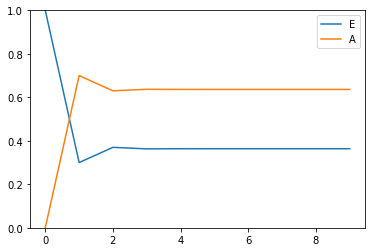

In [33]:
T = np.array([[0.3, 0.4],
              [0.7, 0.6]])

x0 = np.array([1.0, 0.0]).reshape(-1, 1)

# First, second, and third time step evolutions for example,
print(np.hstack([x0, T.dot(x0), T.dot(T.dot(x0))]))

def state_occupation(x0, T, steps):
    # This following line is rather involved Python
    # Just replace it, but you can assume that the line is correct
    # to compare results
    return np.array(sum((list(reduce(np.dot, [x0.T] + [T.T]*i)) for i in range(steps)), []))

x = state_occupation(x0, T, 10)
plt.plot(x[:, 0])
plt.plot(x[:, 1])
plt.legend(['E', 'A'])
plt.ylim([0, 1])
plt.show()

**Problem:** At each timestep, find the most likely state. Meaning if E has more occupation than A, then E is more likely.

In [35]:
def most_likely(x0, T, steps, states=['E', 'A']):
    # Replace the line with your own code
    return [states[i] for i in np.argmax(state_occupation(x0, T, steps), axis=1)]

most_likely(x0, T, 10)

['E', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']

The output list should agree with the plot from the previous problem

## Language Modeling

Markov chains can be useful for generating fake words that mimic structures in the language. Let's look at a sample of text from [English](https://en.wikipedia.org/wiki/Donald_Trump),

In [70]:
import requests, re
en = requests.get('http://www.gutenberg.org/files/74/74-0.txt').text.lower()
en = re.sub('[^a-z]+', ' ', en) # Remove all non-alphabet characters
print(len(en)/255)

1545.043137254902


We can train a Markov chain simply by computing the transition probabilities between letters. Note that I add a 1.0e-3 to the initial matrix. This is called [Additive smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) and although not needed, makes my life easier by avoiding dividing by zero.

In [84]:
N = 2

T_en = np.zeros((256*N, 256*N))

for chars in zip(*[en[i:len(en)-2*N+i] for i in range(1, 2*N+1)]):
    chars = np.array(list(map(ord, chars)))
    init, final = chars[:N], chars[N:]
    if np.all(chars < 256):
        T_en[np.sum(init*256**np.arand(N)), np.sum(final*256**np.arand(N))] += 1.0

print(np.sum(T_en))
T_en /= np.sum(T_en, axis=1).reshape(-1, 1) + 1e-3

393985.0


I can generate a simple word by using the most likely function above,

In [85]:
for starting_letter in 'asdfghjklqwertyuiop':
    x0 = np.eye(255)[ord(starting_letter)].reshape(-1, 1)
    states = [chr(i) + chr(j) for i in range(255), ]
    print(''.join(most_likely(x0, T_en, 50, states)))

angwengwjnghwnghththtttttttttttttttttttttttttttttt
s wexgwexgwengwanthttttttttttttttttttttttttttttttt
d jhm whmgwhngwhn tttttttttttttttttttttttttttttttt
fffomgwoxgxgrgrththttttttttttttttttttttttttttttttt
ghw jhwhjhwhwhwhththtttttttttttttttttttttttttttttt
hexgwexghjzjhwhwhththttttttttttttttttttttttttttttt
juzgwgxghjrjhwhwhththttttttttttttttttttttttttttttt
kexhmgxhwgxhngrtht ttttttttttttttttttttttttttttttt
llljuzzjhw jhw whthttttttttttttttttttttttttttttttt
quzkwgxjugxjhg wht thttttttttttttttttttttttttttttt
wangwhzgwhngwbnd thttttttttttttttttttttttttttttttt
exjhexjhj jhw whththtttttttttttttttttttttttttttttt
rexongxjngxjhw whthttttttttttttttttttttttttttttttt
thexghjzjhw jhwhwhthtttttttttttttttttttttttttttttt
y jhx whvgwhngwhn tttttttttttttttttttttttttttttttt
uzkwgxjugxjhg wht thtttttttttttttttttttttttttttttt
izgwhzgwazghwndhththtttttttttttttttttttttttttttttt
ougrengxjng whwhththtttttttttttttttttttttttttttttt
pplgwezgwbnghwndhthttttttttttttttttttttttttttttttt


Admittedly not that great. We can do better if at each step, we collapse the state down to whatever letter we chose in the previous step and add in an alternate sampling scheme. **This probably won't make sense! Ask about it in class**

In [86]:
def evolve(x0, T, steps, states):
    output = [states[np.argmax(x0)]]
    for i in range(steps):
        x0 = T.dot(x0)
        x0 /= np.sum(x0) # Normalize probabilities
        i = np.random.choice(np.arange(x0.shape[0]), p=x0.flatten()) # Random weighted sampling
        output.append(states[i])
        x0 = np.eye(x0.shape[0])[i]
    return output

In [88]:
for starting_letter in 'asdfghjklqwertyuiop':
    x0 = np.eye(255)[ord(starting_letter)].reshape(-1, 1)
    states = list(map(chr, range(255)))
    print(''.join(evolve(x0, T_en, 50, states)))

acy jok quarywelyonjurkevedrsply tigand hizzzzzzzzz
shanedownolingofifo ju cksqugrooubonybybyzzzzzzzzze
divybungalyseremprnsut sith quld fing tizzzzzzzzzzz
fary boumpurromofrwinasiplyojodiximprmirmulllkelexv
gove jonoofiney quprgooouth bupigugorshuld jacecowe
hoy tckerppusquzzzyodsmpomplat mivixxphevy mppizzzz
julldngersper fevidduplyejovitibupinthacl azzzzzzzz
kexxxxxxxxxvenchazz tsoymbaikisqupabecksqunyzzzzzzz
lk llyovecard fik mashackythigofled bouppeshervespe
quprong y qudy wheryzzzzzzzzzzzzzzzit mbrmbupain hr
withizzzzzzzzzzzzzzzzzexed byzzzzzzzzzzzzzzysk wacr
ethizzzzzzzzzzzzzzzzzzzzzzy pkyskf hexxxxxprnzzzelf
rkorgayomouzzzzzzzizzvequzzzzzzzzzzybloftwoulinjulo
theymoutmuckn burilwd qugucozzvi suporkym obongongo
yorgg qugly ainckndquguphaybutontyzzzzzzzzzzzzzzzzz
uded isckizzzzzzidybunqushecked lkesusmyexxcuthimav
ixxcoucombbazzzzzzzexxxxxxpl ruthexxxxpovimpptfrmpr
oomouzzzzzzzzzzzzvecoighed xpuzzzzzzzzzzzzzzzzercny
p joulympouzzzzzzzzvidsaves hacld towizzzzzzzagar w


A little better. Occasionally, we see actual english words. Still pretty bad though. But this is a pretty naive and basic model. Better models would be possible if we use more advanced algorithms.